# Удержание клиентов фитнес-центров с помощью машинного обучения

## Описание проекта


Цель - разработать стратегию взаимодействия с клиентами фитнес центра на основе аналитических данных, для того, чтобы минимизировать отток.  
Провести анализ и подготовить план действий по удержанию клиентов.  

А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

## Описание данных

Сеть фитнес центров предоставила сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.  
Набор данных включает следующие поля: 
- Данные клиента за предыдущий до проверки факта оттока месяц:
    - `gender` — пол;
    - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
    - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - `Phone` — наличие контактного телефона;
    - `Age` — возраст;
    - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).  
       
       
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
    - `Group_visits` — факт посещения групповых занятий;
    - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
    - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
    - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
    - `Churn` — факт оттока в текущем месяце.

## Исследовательский анализ данных (EDA)

### Первый взгляд и предобработка данных

In [3]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# убираем предупреждения при выводе графиков
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# настраиваем отображение данных типа float
pd.set_option('display.float_format', '{:,.2f}'.format)

In [4]:
# указываем путь до таблицы
path = '/datasets/'

#загружаем данные
try:
    churn_data = pd.read_csv(path + 'rest_data.csv')
except: 
    churn_data = pd.read_csv('gym_churn.csv')

In [5]:
# создаем функцию для первичного ознакомление с датафреймами
def dataset_info(df):
    print('\033[1m' + 'Результат работы метода .info:' + '\033[0m')
    df.info()
    print('*'*50)
    print('\033[1m' + 'Результат работы метода .describe:' + '\033[0m')
    display(df.describe())
    print('*'*50)
    print('\033[1m' + 'Первые 5 строк таблицы:' + '\033[0m')
    display(df.head())
    print('*'*50)
    print('\033[1m' + 'Наличие дубликатов в таблице:' + '\033[0m')
    print(df.duplicated().sum())

In [6]:
dataset_info(churn_data)

Результат работы метода .info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


**************************************************
Первые 5 строк таблицы:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


**************************************************
Наличие дубликатов в таблице:
0


В датасете нет пропусков и дубликатов.  
Отсутствующих признаков нет.  
Средние значения признаков: 
- gender - 0.51, клиенты данной сети распределены по полу почти поровну
- Near_Location - 0.85, 85% клиентов живут или работают рядом с фитнес центром
- Partner - 0.49, почти половина клиентов сети - сотрудники компаний-партнеров, имеющие возможность получать скидки на абонимент
- Promo_friends - 0.31, 31% клиентов первый раз пришли в зал, воспользовавшись акцией "Приведи друга".
- Phone	- 0.90, 90% клиентов оставили свой контактный номер телефона
- Contract_period - средний срок действующего абонимента - 4.68 месяца (из вариантов 1, 6, 12).
- Group_visits - 0.41, 41% пользователей посещали хотя бы 1 групповое занятие
- Age - средний возрас чуть больше 29 лет.
- Avg_additional_charges_total - средняя выручка от дополнительных услуг - 146.94 у.е.
- Month_to_end_contract - средний оставшийся срок действующего абонимента - 4.32 месяца
- Lifetime - среднее время с момента первого обращения - 3.72 месяца
- Avg_class_frequency_total - средняя частота посещений в неделю за все время с начала действия абонемента - 1.88 раз в неделю.
- Avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц - 1.77 раз в неделю.
- Churn - 0.27 - 27% клиентов из указанного датасета перестали пользоваться услугами центра.

In [7]:
# посмотрим на все уникальные значения столбца Month_to_end_contract
churn_data['Month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

Видим, что в столбце представлены только целые число, переведем его в верный тип.

In [8]:
# переведем столбец 'Month_to_end_contract' в тип int
churn_data['Month_to_end_contract'] = churn_data['Month_to_end_contract'].astype('int')

Теперь все столбцы в датафреймы представлены в верном типе данных.

In [9]:
# приведем название колонок к общепринятому стандарту
churn_data.columns = [x.lower() for x in churn_data.columns]
churn_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0


Теперь названия колонок названы с учетом общепринятого стиля.

#### Вывод

В датасете нет пропусков и дубликатов.  
Отсутствующих признаков нет.  
Ознакомились со средними значениями и стандартным отклонением признаков.  
Тип данных столбца 'Month_to_end_contract' приведен к нужному формату.    
Названия колонок переименованы с учетом общепринятого стиля.  

### Средние значеня признаков для ушедших и оставшихся клиентов

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [10]:
# сгруппируем данные по факту оттока пользователя и вычислим средние значения показателей.
churn_data.groupby('churn', as_index = False).mean()

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


#### Вывод

Видно, что следующие факторы могут влиять на отток клиента:
- `near_location` в группе ушедших меньше клиентов жили или работали рядом с залом
- `partner` в группе ушедших меньше клиентов, из компаний-партнеров
- `promo_friends` в группе ушедших меньше тех, кто воспользовался акцией "приведи друга"
- `contract_period` ушедшие чаще покупают абонимент на 1 месяц
- `group_visits` в группе ушедших меньше клиентов пользовались групповыми занятиями
- `age в группе` ушедших клиенты в среднем младше на 3 года
- `avg_additional_charges_total` в группе ушедших клиенты меньше тратили денег на доп услуги центра
- `month_to_end_contract` в группе ушедших время до конца абонимента заметно ниже 1.66 против 5.28 месяцев.
- `lifetime` в группе ушедших среднее значение времени с первого контакта заметно ниже
- `avg_class_frequency_total`, `avg_class_frequency_current_month` - видно, что в группе ушедших среднее количество посещений за весь период меньше на 0.5, а среднее количество посещений неделю в текущей месяц на 1.

А вот средние значения `gender` и `phone` одинаковые, вероятно данные признаки не влияют на отток клиентов.

### Распределения признаков для ушедших и оставшихся клиентов

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

In [11]:
# cоберем названия признаков в отдельном списке
features = list(churn_data)

# удалим признак churn
features.remove('churn')

features

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month']

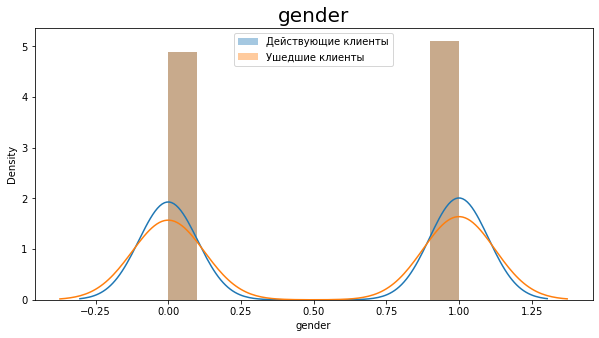

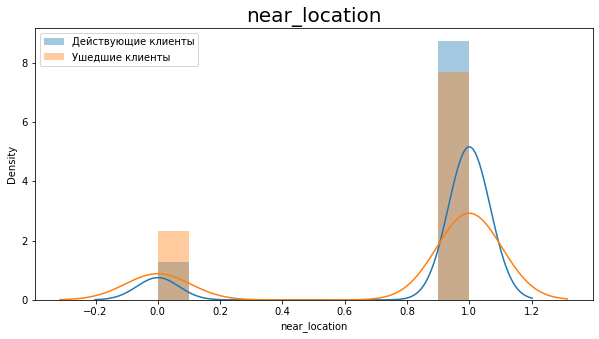

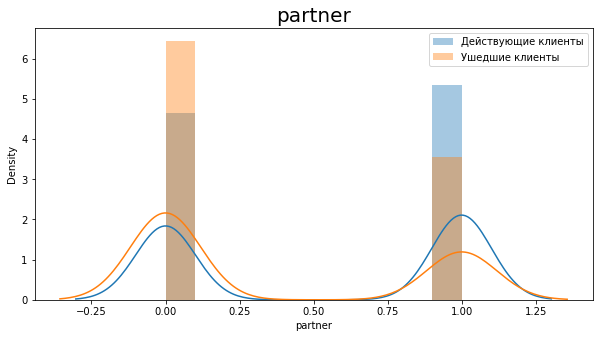

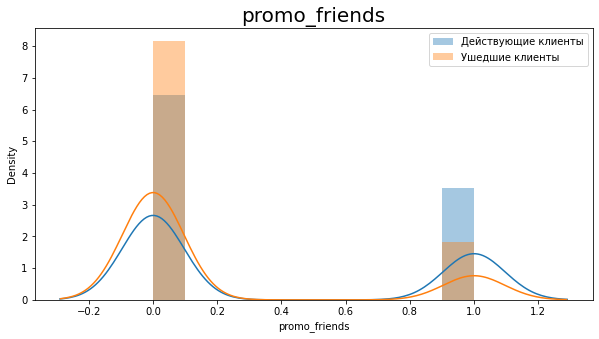

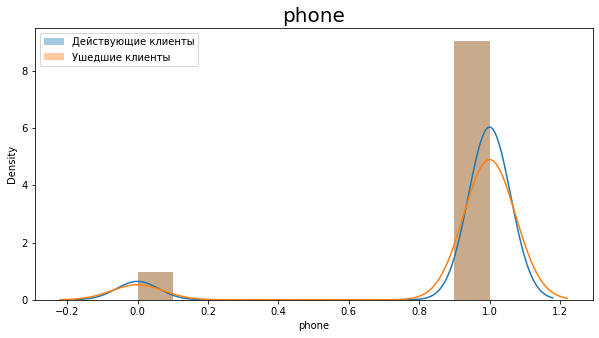

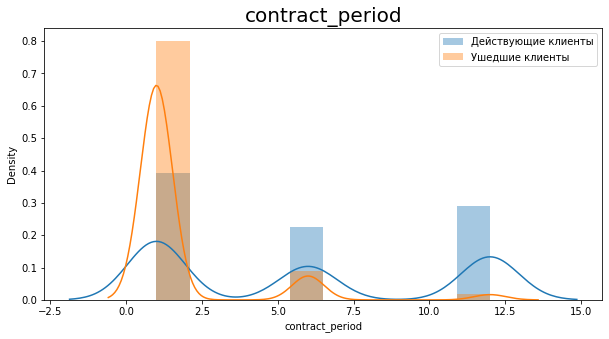

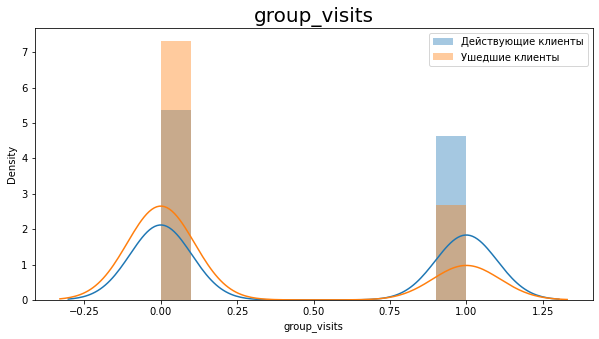

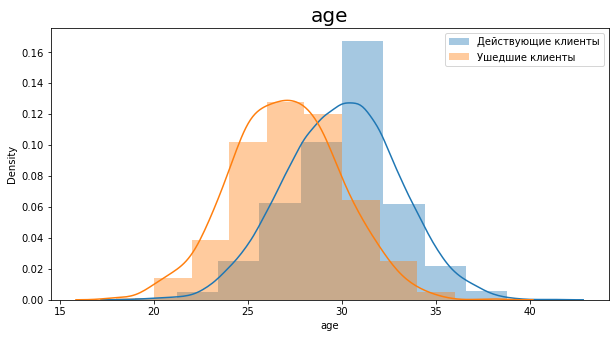

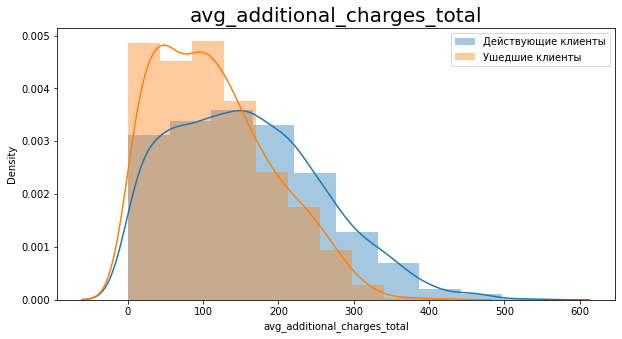

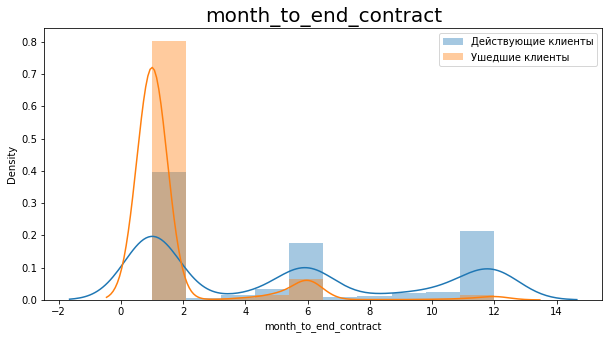

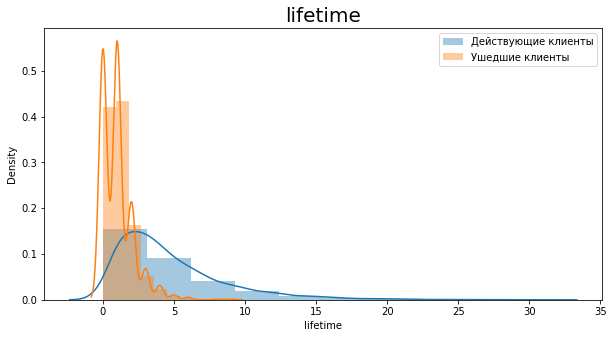

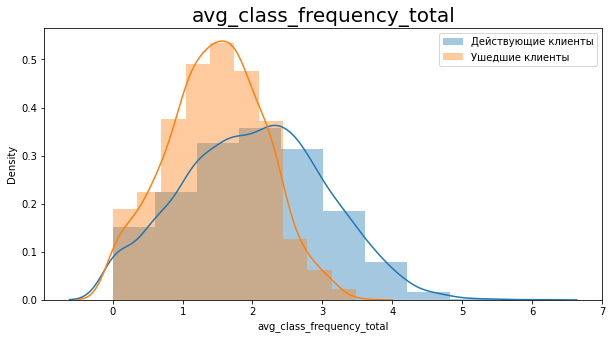

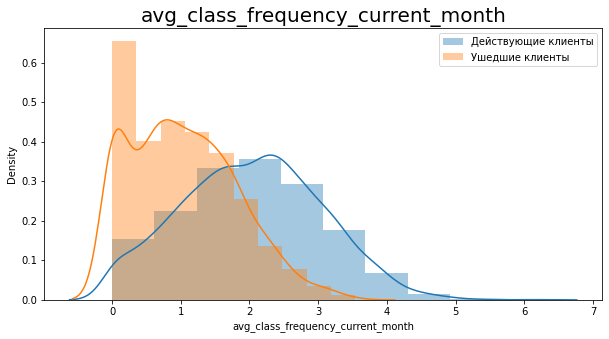

In [12]:
for feature in features:
    plt.figure(figsize = (10, 5))
    sns.distplot(churn_data[churn_data['churn'] == 0][feature], bins = 10, label='Действующие клиенты')
    sns.distplot(churn_data[churn_data['churn'] == 1][feature], bins = 10, label='Ушедшие клиенты')
    plt.legend()
    plt.title(feature, fontsize=20)
    plt.show();

#### Вывод

Наблюдения, полученные благодаря таблице, сгруппированной по значению параметра оттока подтвердились.

`gender` и `phone` не влияют на отток клиентов, распределение по данному критерию одинаковое и для действующих клиентов и для ушедших. Данные признаки следует удалить до обучения модели.

Влияние остальных признаков на вероятность оттока клиента:
- `near_location` клиенты, которые живут или работают рядом с залом реже перестают пользоваться услугами зала и наоборот.
- `partner` если клиент работает в компании - партнере, то вероятность его ухода ниже, видимо на это влияет более выгодные условия на покупку абонимента
- `promo_friends` реже уходят пользователи, воспользовавшиеся промо акцией "Приведи друга".
- `contract_period` среди тех, кто купил абонимент на 1 месец ушедших клиентов в 2 раза больше, чем оставшихся, при покупке абонимента на 6 месяцев ушедших менее 30%, а при покупке абониментов на 12 месяцев уходят меньше 10%. Чем больше срок покупаемого абонимента, чем меньше вероятность оттока клиента.
- `group_visits` посещение групповых занятий уменьшает вероятность оттока клиента.
- `age` чем меньше возраст, тем больше вероятность оттока клиента. Оба распределения нормальны, медианное значение возраста для действующих клиентов сдвинуто на 3 года в сторону увеличения.
- `avg_additional_charges_total` в группе ушедших клиенты меньше тратили денег на дополнительные услуги центра.
- `month_to_end_contract` чем больше месяцев до конца обонемента, тем меньше вероятность ухода клиента.
- `lifetime` чем дольше человек пользуется услугами сети фитнес центров, тем меньше вероятность его ухода.
- `avg_class_frequency_total`, `avg_class_frequency_current_month` - чем больше раз в неделю занимается клиент, тем менее вероятен его отток, это справедливо как для наблюдений за всю историю посещения, так и для наблюдений за последний месяц.

### Матрица корреляции признаков

Порстроим матрицу корреляции признаков для исключения возможной мультиколлиниарности признаков.

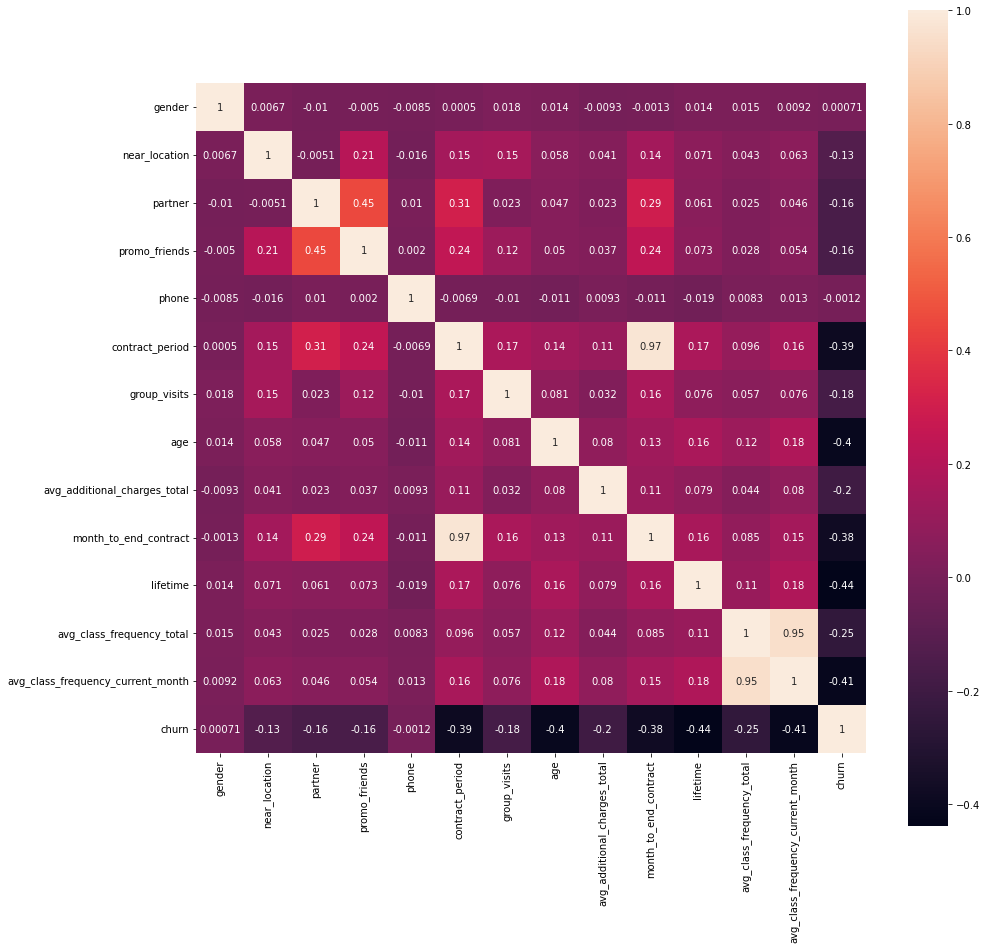

In [13]:
# вычисляем матрицу корреляции
cm = churn_data.corr()

# выводим ее значения в виде тепловой карты
plt.figure(figsize = (15, 15))
sns.heatmap(cm, annot=True, square=True);

Сильно коррелируют признаки: `month_to_end_contract` c `contract_period` (0.97) и `avg_class_frequency_total` c `avg_class_frequency_current_month` (0.95).    

Чтобы избавиться от мультиколлинеарности, удалим из датафрейма один признак из каждой пары.  
Также удалим невлияющие на отток клиента признаки `gender` и `phone`.

In [14]:
# удаляем невлияющие и по 1 из пар мультиколлинеарных признаков из датафрейма
churn_data.drop(['avg_class_frequency_total', 'contract_period', 'gender', 'phone'], axis = 1, inplace = True)

In [15]:
# проверяем результат
churn_data.head()

,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,29,14.23,5,3,0.00,0
1,1,0,0,1,31,113.20,12,7,1.91,0
2,1,1,0,0,28,129.45,1,2,1.74,0
3,1,1,1,1,33,62.67,12,2,3.36,0
4,1,1,1,0,26,198.36,1,3,1.12,0


#### Вывод

Были выявлены сильно коррелирующие признаки: `month_to_end_contract` c `contract_period` и `avg_class_frequency_total` c `avg_class_frequency_current_month`.

Чтобы избавиться от мультиколлинеарности, было удалено по одному признаку из каждой пары, а именно: `avg_class_frequency_total`, `contract_period`.  

Также удалены невлияющие на отток клиента признаки `gender` и `phone`.

### Вывод

**Провели предобработку данных.**

**Определили какие признаки влияют на отток и как проявляется их влияние:**
`gender` и `phone` не влияют на отток клиентов, распределение по данному критерию одинаковое и для действующих клиентов и для ушедших. Данные признаки следует удалить до обучения модели.

Влияние остальных признаков на вероятность оттока клиента:
- `near_location` клиенты, которые живут или работают рядом с залом реже перестают пользоваться услугами зала и наоборот.
- `partner` если клиент работает в компании - партнере, то вероятность его ухода ниже, видимо на это влияет более выгодные условия на покупку абонимента
- `promo_friends` реже уходят пользователи, воспользовавшиеся промо акцией "Приведи друга".
- `contract_period` среди тех, кто купил абонимент на 1 месец ушедших клиентов в 2 раза больше, чем оставшихся, при покупке абонимента на 6 месяцев ушедших менее 30%, а при покупке абониментов на 12 месяцев уходят меньше 10%. Чем больше срок покупаемого абонимента, чем меньше вероятность оттока клиента.
- `group_visits` посещение групповых занятий уменьшает вероятность оттока клиента.
- `age` чем меньше возраст, тем больше вероятность оттока клиента. Оба распределения нормальны, медианное значение возраста для действующих клиентов сдвинуто на 3 года в сторону увеличения.
- `avg_additional_charges_total` в группе ушедших клиенты меньше тратили денег на дополнительные услуги центра.
- `month_to_end_contract` чем больше месяцев до конца обонемента, тем меньше вероятность ухода клиента.
- `lifetime` чем дольше человек пользуется услугами сети фитнес центров, тем меньше вероятность его ухода.
- `avg_class_frequency_total`, `avg_class_frequency_current_month` - чем больше раз в неделю занимается клиент, тем менее вероятен его отток, это справедливо как для наблюдений за всю историю посещения, так и для наблюдений за последний месяц.

**Мультиколлинеарность**  
Были выявлены сильно коррелирующие признаки: `month_to_end_contract` c `contract_period` (0.97) и `avg_class_frequency_total` c `avg_class_frequency_current_month` (0.95).

**Удаление признаков**  
Чтобы избавиться от мультиколлинеарности, было удалено по одному признаку из каждой пары, а именно: `avg_class_frequency_total`, `contract_period`.   

Также удалены невлияющие на отток клиента признаки `gender` и `phone`.

## Построим модель прогнозирования оттока клиентов

Построим 2 модели бинарной классификации клиентов, с целевым признаком — факт оттока клиента в следующем месяце.

Для этого разобьем данные на обучающую и валидационную выборку.

In [16]:
# выделяем целевой признак
y = churn_data['churn']

# собираем остальные нецелевые признаки
X = churn_data.drop(['churn'], axis=1)

In [17]:
# разбиваем данные на обучающую и валидационную выборки.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

Обучим модель на train-выборке двумя способами:
- логистической регрессией,
- случайным лесом.


Стандартизируем выборки.

In [18]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

# обучаем scaler, трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(
    X_train
)  

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [19]:
# задаем список моделей
models = [
    LogisticRegression(random_state=17),
    DecisionTreeClassifier(random_state=17),
]

In [20]:
# создадим функцию делующую прогнозы и оценивающую ее по основным метрикам
def make_prediction(model, X_train,y_train,X_test,y_test):
    result = {}
    model = model
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    result[model] = {'Accuracy':round(accuracy_score(y_test, predict),3),
                    'Precision':round(precision_score(y_test, predict),3),
                    'Recall':round(recall_score(y_test, predict),3)}
    print(result)

In [21]:
# применим функцию и выведем результаты метрик
for model in models:
    make_prediction(model, X_train_st, y_train, X_test_st, y_test)

{LogisticRegression(random_state=17): {'Accuracy': 0.909, 'Precision': 0.806, 'Recall': 0.819}}
{DecisionTreeClassifier(random_state=17): {'Accuracy': 0.866, 'Precision': 0.703, 'Recall': 0.772}}


### Вывод

По всем метрикам LogisticRegression лучше, чем DecisionTreeClassifier в данном случае:
- `Accuracy` - Доля правильных ответов больше: 0.909 против 0.866;
- `Precision` - Долю правильных ответов только среди целевого класса больше: 0.806 против 0.703;
- `Recall` - Доля обнаруженных фактов оттока от общего числа 0.819 против 0.772.

## Выполним кластеризацию клиентов

Выполним кластеризацию клиентов, для этого сначала стандартизируем данные.

In [22]:
# создадим объект класса scaler (нормализатор)
scaler = StandardScaler()

# обучим нормализатор и преобразуем набор данных без целевого признака
x_sc = scaler.fit_transform(churn_data.drop(columns = ['churn'])) 

### Построим матрицу расстояний

In [23]:
# передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage()
linked = linkage(x_sc, method = 'ward')

Теперь построим дендрограмму

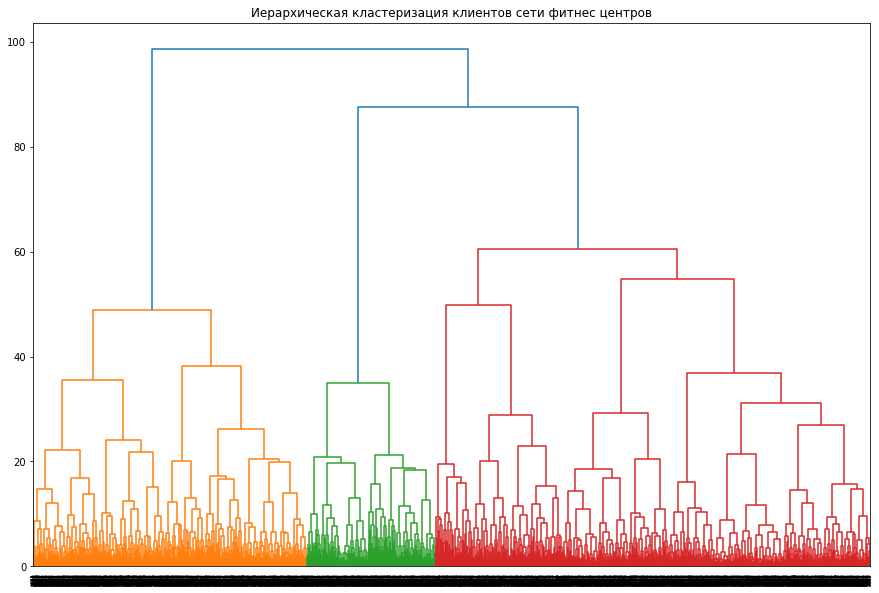

In [24]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов сети фитнес центров')
plt.show()

Исходя из результатов построения дендограммы видим, что алгоритм предлагает разбить клиентов на 3 кластера.  
Но на дендограмме видим, что можно выделить 5 кластеров клиентов.  
Разделим совокупность клиентов на 5 кластеров методом Kmeans в следующем блоке.

### Обучим модель кластеризации на основании алгоритма K-Means

Алгоритм K-Means основан на предположении, что число кластеров (групп) заранее известно, передадим ему число кластеров, равное 5.

Данные уже были стандартизированы в начале 5ого блока.

In [25]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters=5, random_state=17) # задаём число кластеров, равное 5

# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(x_sc)

In [26]:
# добавляем метки кластеров к данным о пользователях
churn_data['cluster'] = labels

Сгруппируем данные по кластерам.

In [27]:
churn_data.groupby('cluster').mean().T

cluster,0,1,2,3,4
near_location,0.99,1.00,1.00,0.96,0.00
partner,0.96,0.25,0.24,0.52,0.49
promo_friends,0.98,0.06,0.08,0.21,0.07
group_visits,0.50,0.00,1.00,0.37,0.23
age,29.53,28.59,29.44,30.21,28.69
avg_additional_charges_total,151.22,139.07,145.75,175.77,137.27
month_to_end_contract,6.66,2.83,4.03,5.80,2.72
lifetime,3.61,2.32,2.81,11.40,2.77
avg_class_frequency_current_month,1.87,1.55,1.79,2.34,1.58
churn,0.14,0.42,0.23,0.00,0.41


### Интерпритация результатов кластеризации алгоритмом K-Means

**Характерные признаки кластеров:**
- Кластер №0:
    - 99% клиентов занимаются вблизи места работы или учебы
    - 96% клиентов из компаний-партнеров
    - 98% клиентов участвовали в программе "Приведи друга"
    - Самый большой срок до окончания абонемента среди остальных кластеров
    - Второй срок по времени с момента первого обращения в фитнес-центр среди остальных кластеров, уступает только 3 кластеру
    - Достаточно высокое значение частоты посещений, уступает только 3 кластеру
    - Низкий процент оттока клиентов - 0.14
  
  
**Ожидаемый результат, нет ярко выраженных негативных признаков в кластере, но и его можно улучшить, склонив пользователей к групповым занятиям**  
    
    
- Кластер №1:
    - Все клиенты занимаются вблизи места работы или учебы
    - Низкий уровень количества клиентов из компаний - партнеров
    - Низкий уровень количества клиентов, воспользовавшихся акцией "Приведи друга".
    - Никто из пользователей кластера не пользовался групповыми занятиями
    - Самый молодой кластер
    - Низкие траты на сопутствующие услуги
    - В данном кластере самые "молодые" клиенты по сроку использования услуг сети центров
    - Самый низкий показатель посещения за последний месяц
    - Самый высокий процент оттока клиентов - 0.42
   
**Несмотря на близость к работе или дому, из-за малого значения клиентов из компаний-партнеров, из-за малого количества клиентов, которые воспользовались акцией "Приведи друга", из-за непосещения клиентами групповых занятий, низкого показателя посещения за последний месяц, процент оттока очень высок. С этим кластером можно работать для увеличения удержания.**  
    
    
- Кластер №2:
    - Все клиенты занимаются вблизи места работы или учебы
    - Самый низкий уровень количества клиентов из компаний - партнеров
    - Самый низкий уровень количества клиентов, воспользовавшихся акцией "Приведи друга".
    - Все пользователи пробовали групповое занятие хотя бы раз
    - Средний процент оттока клиентов - 0.23
    
    
**Не смотря на то, что клиенты не пользуются привелегиями компаний - партнеров и акцией "Приведи друга" отток не так велик, полагаю это связано с тем, что у данного кластера популярны групповые занятия, которые способствует удержанию клиента.**
    
    
    
- Кластер №3:
     - 96% клиентов занимаются вблизи места работы или учебы
     - Самые взрослые клиенты среди остальных кластеров
     - Самые большие расходы на доп.услуги
     - В данном кластере самые "старые" клиенты по сроку использования услуг сети центров, рекордные 11.4 месяца в среднем
     - Самый высокий показатель частоты посещений в неделю
     - Нет оттока клиентов
     

**Рекордный кластер, клиенты "прикипели" к залу, часто его посещают, в среднем они ходят в него уже целый год, да и возраст самый большой, что благотворно влияет на отток.**

- Кластер №4:
     - Все клиенты занимаются вдали от дома или работы
     - Почти самый низкий уровень количества клиентов, воспользовавшихся акцией "Приведи друга".
     - Низкий уровень заинтересованности в групповых занятиях
     - Самые малые средние затраты на доп услуги
     - Реже остальных кластеров посещают зал.
     - Высокий процент оттока клиентов - 0.41

**Клиентам вероятно сложно добираться до зала, мало пользователей попробовали групповые занятия, клиенты из данного кластера редко пользуются дополнительными услугами и посещают зал**

### Построим распределения признаков для кластеров

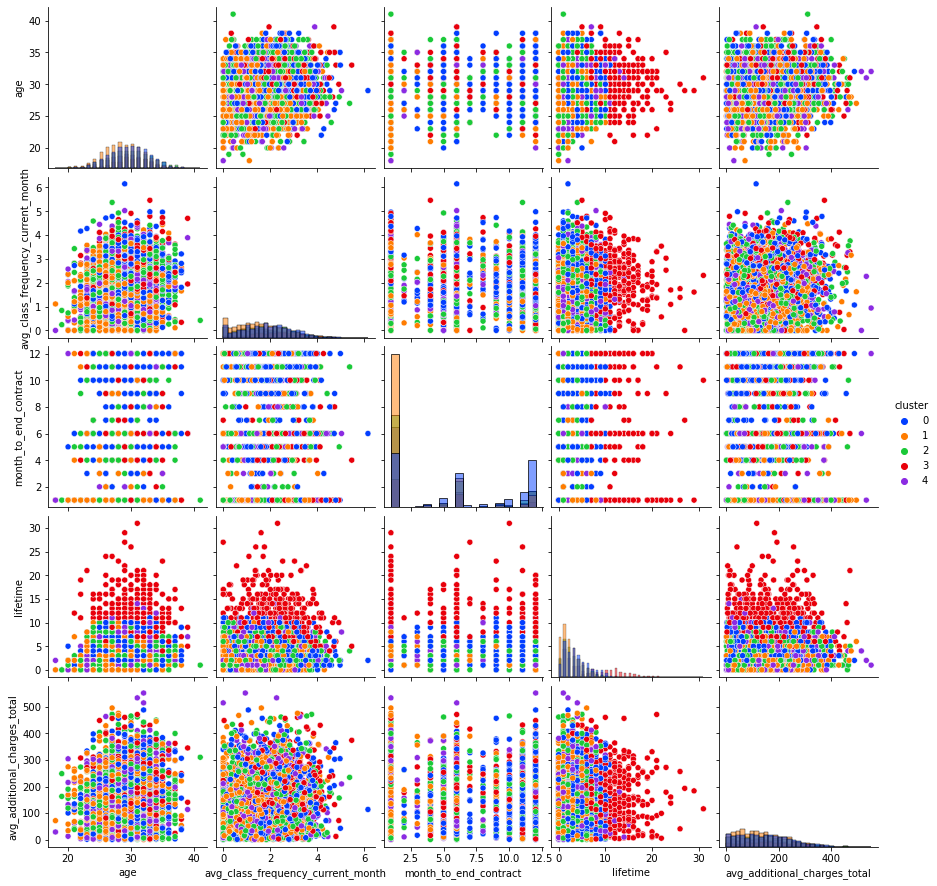

In [42]:
sns.pairplot(churn_data,
             vars= ['age',
                    'avg_class_frequency_current_month',
                    'month_to_end_contract',
                    'lifetime',
                    'avg_additional_charges_total'],
             hue='cluster',
             diag_kind="hist",
             palette = "bright");

Видно, что в третий кластер входят самые "старые" клиенты по времени, прошедшего с первым контактом с сетью фитнес центров, что первый кластер меньше тратит на сопутствуюшие услуги.  
Это подтверждает выводы, сделанные по сгруппируем по кластерам таблице.

### Посчитаем долю оттока для каждого полученного кластера

In [54]:
# сгруппируем пользователей по кластеру и посчитаем количество ушедших и общее количество пользователей
churn_percentage = churn_data.groupby('cluster', as_index = False)\
    .agg({'month_to_end_contract':'count', 'churn':'sum'})

# переименовываем рассчитываемые колонки
churn_percentage.columns = ['cluster', 'count_user', 'churn_count']

# определяем процент оттока по кластерам
churn_percentage['churn_percentage_in_cluster'] = churn_percentage['churn_count'] / churn_percentage['count_user']

# определяем процент оттока от общего количества клиентов
churn_percentage['churn_total_percentage'] = churn_percentage['churn_count'] / churn_percentage['count_user'].sum()

churn_percentage.sort_values(by = 'churn_total_percentage', ascending = False)

,cluster,count_user,churn_count,churn_percentage_in_cluster,churn_total_percentage
1,1,1145,483,0.42,0.12
4,4,597,245,0.41,0.06
2,2,865,197,0.23,0.05
0,0,991,136,0.14,0.03
3,3,402,0,0.00,0.00


Больше всего пользователей из сети ушло из 1 кластера, это самый большой кластер и здесь самый большой процент оттока клиентов.  
За ним идут 4(6%), 2(5%), и 0 кластеры - 6%, 5% и 3% соответственно от общего количества клиентов в сети фитнес центров.  
Из 3его кластера не ушел ни 1 клиент.

## Выводы и базовые рекомендации

Единственный надежный кластер - 3 из него клиенты не уходят вовсе.  
Менее надежные кластеры - 0 и 2, из них уходят 14% и 23% клиентов соответственно.  
Самое большое внимание следует обратить на кластеры 1 и 4, из них уходят более 40% пользователей, особенно на 1 кластер, он самый многочисленный, только из него уходят 12% от общего количетсва клиентов сети фитнес центров.  

Рекоммендации по кластерам:  

**Кластер №0**
- Увеличить частоту посещения групповых занятий

**Кластер №1**
- Увеличить частоту посещения групповых занятий
- Стимулировать пользователей пользоваться акцией "Приведи друга"
- Стимулировать пользоваться сопутствующими услугами
- Предложить компаниям неподалеку партнерскую программу

**Кластер №2**
- Стимулировать пользователей пользоваться акцией "Приведи друга"
- Предложить компаниям неподалеку партнерскую программу

**Кластер №4**
- Предложить возможность прикрепиться к другому филиалу сети фитнес центров, ближе к дому/работе
- Стимулировать пользователей пользоваться акцией "Приведи друга"
- Стимулировать пользоваться сопутствующими услугами
- Увеличить частоту посещения групповых занятий

Подробнее о каждой рекоммендации:
- Увеличить частоту посещения групповых занятий - согласно исследованию, данный параметр благотворно влияет на количество отказов. Вероятно люди находят знакомых или даже друзей, привыкают к тренерам, ведущим занятия, что мешает им поменять зал в будущем.  
- Стимулировать пользователей пользоваться акцией "Приведи друга" - наличие друга или приятеля в зале благотворно влияют на удержание. Ходить в компании всегда легче, да и в сложные периоды друг поддержит и поможет не бросить полезную для клиента привычку.  
- Стимулировать пользоваться сопутствующими услугами - сопутствующие услуги могут быть очень полезны, но недооценны клиентами. Например опция большого полотенца, душевых принадлежностей или аренды шкафчика позволят значительно повысить комфорт посещения зала, а стоить могут немного.  
- Предложить компаниям неподалеку партнерскую программу - в 1 и во 2 кластере малая доля клиентов из партнерских программ.  Возможно это связано с территориальным расположением залов в которые ходят клиенты из данных кластеров. Можно провести дополнительное исследование, посмотреть не сгруппированы спортивные центры пользователей из данных кластеров территориально? Можно было бы предложить компаниям поблизости партнерскую программу, это может быть в интересах обоих сторон.
- Предложить возможность прикрепиться к другому филиалу сети фитнес центров, ближе к дому/работе - дорога в городах может отнимать много времени и сил, что негативно влияет на отток. Программа, позволяющая перепривязать свой абонимент к другому центру может значительно уменьшить отток из 4 кластера.